In [1]:
import re

import numpy as np 
import pandas as pd
import seaborn as sns
import Stemmer as py_stemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from imblearn.combine import SMOTEENN, SMOTETomek


In [2]:
DATA_PATH = "../data/all_tickets.csv"


RANDOM_STATE = 0
PRIORITY_COLUMN = "urgency"

TICKET_TYPES = {0: "incident", 1: "request"}

CATEGORIES = {
    0: "lacking information",
    6: "access",
    5: "hardware",
    4: "action",
    7: "location",
    11: "access card",
    8: "database",
    9: "purchase",
}

DESCRIPTION_REGEX = re.compile("(\W|\d)+")

In [10]:
df = pd.read_csv(DATA_PATH)
df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [4]:
df['category'].value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [11]:
MIN_CATEGORY_COUNT = 150

selected_categories = set(
    map(
        lambda c: c[0],
        filter(
            lambda i: i[1] >= MIN_CATEGORY_COUNT,
            enumerate(df.category.value_counts().sort_index().values),
        ),
    )
)

df = df[df.category.isin(selected_categories)]
df = df.drop(["sub_category1", "sub_category2", "business_service"], axis=1)
df["title"] = df.title.fillna("")
df = df[~df.title.isna()]
df.head()

,title,body,ticket_type,category,urgency,impact
0,,hi since recruiter lead permission approve req...,1,4,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,3,4
2,work experience user,work experience user hi work experience studen...,1,5,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,3,4


In [7]:
from typing import Callable, List


def clean_input_string(s: str) -> str:
    return DESCRIPTION_REGEX.sub(" ", s).strip()


def preprocess_string(
    s: str,
    stemmer: py_stemmer.Stemmer,
    tokenizer: Callable[[str], np.array] = CountVectorizer(
        ngram_range=(2, 2)
    ).build_analyzer(),
) -> List[str]:
    return [
        " ".join(stemmer.stemWords(gram.split()))
        for gram in tokenizer(clean_input_string(s))
    ]


test_stemmer = py_stemmer.Stemmer("english")
assert preprocess_string(
    "Hello. This is a sentence with a lot of puncutation: (1) many letters and (b) a lot of @special#characters%    \t\n\n\s .......?!",
    test_stemmer,
) == [
    "hello this",
    "this is",
    "is sentenc",
    "sentenc with",
    "with lot",
    "lot of",
    "of puncut",
    "puncut mani",
    "mani letter",
    "letter and",
    "and lot",
    "lot of",
    "of special",
    "special charact",
]


In [16]:
def generate_features(
    df: pd.DataFrame, vectorizer: Callable[[str], np.ndarray]
) -> pd.DataFrame:
    df = df.copy()
    for col in ("title", "body"):
        vec = f"{col}_vector"
        df[vec] = vectorizer(df[col])
        df[f"{col}_length"] = df[col].apply(len)
        # df[f"{col}_skew"] = skew(df[vec])
        # df[f"{col}_kurtosis"] = kurtosis(df[vec])
    return df

In [12]:
stemmer = py_stemmer.Stemmer("english")
vectorizer = TfidfVectorizer(analyzer=lambda s: preprocess_string(s, stemmer))
body_vectors = vectorizer.fit_transform(df.body.values)
title_vectors = vectorizer.fit_transform(df.title.values)

svd = TruncatedSVD(n_components=1000, random_state=RANDOM_STATE)
body_vectors = svd.fit_transform(body_vectors)
title_vectors = svd.fit_transform(title_vectors)
# df["body_vec"] = None
# df["body_vec"] = df["body_vec"].astype(object)
# df["body_vec"] = body_vectors

# df["title_vec"] = None
# df["title_vec"] = df["title_vec"].astype(object)
# df["title_vec"] = title_vectors
# df.head()
in_features = np.hstack([title_vectors, body_vectors])
in_features.shape

in_features_original = in_features

In [13]:
le = LabelEncoder()
le.fit(df.category.unique())
categories = le.transform(df.category)
priorities = df.urgency.values
# training_objective = categories
training_objective = priorities

p = np.random.permutation(len(in_features_original))
in_features_original, training_objective = in_features_original[p], training_objective[p]

resampler = SMOTETomek(random_state=RANDOM_STATE, n_jobs=-1)

from time import time

start = time()
in_features, training_objective = resampler.fit_resample(
    in_features_original, training_objective
)
end = time() - start
print(f'{end}s')

# tmp_x, tmp_y = resampler.fit_resample(
#     in_features_original[7000:20000], training_objective[7000:20000]
# )

842.6558730602264s


In [14]:
import pickle
with open("../data/features_urgency.pkl", "wb") as f:
    pickle.dump(in_features, f)
with open("../data/objectives_urgency.pkl", "wb") as f:
    pickle.dump(training_objective, f)

In [15]:
n_classes = len(set(training_objective))
X_train, X_test, y_train, y_test = train_test_split(
    in_features, #new_df[["title_vector", "body_vector", "title_length", "body_length"]],
    training_objective, # categorical labels
    test_size=0.4,
    random_state=RANDOM_STATE,
)

In [16]:
# Baseline model
reg = LogisticRegression(max_iter=1000, verbose=1)
reg.fit(X_train, y_train)
print("Train Accuracy: {}".format(accuracy_score(reg.predict(X_train), y_train)))
print("Test Accuracy: {}".format(accuracy_score(reg.predict(X_test), y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


Train Accuracy: 0.7598065296251512
Test Accuracy: 0.7468168462291871


In [17]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
     objective="multi:softmax",
    #  max_depth=5,
     n_estimators=50,
     num_classes=n_classes,
     verbose=1,
 )
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
print("Train Accuracy: {}".format(accuracy_score(xgb_clf.predict(X_train), y_train)))
print("Test Accuracy: {}".format(accuracy_score(xgb_clf.predict(X_test), y_test)))

/home/george/.cache/pypoetry/virtualenvs/ml-mmRLi81b-py3.9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:25:46] WARNING: ../src/learner.cc:541: 
Parameters: { num_classes, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:26:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.20781
[1]	validation_0-mlogloss:1.08860
[2]	validation_0-mlogloss:1.00639
[3]	validation_0-mlogloss:0.94254
[4]	validation_0-mlogloss:0.89338
[5]	validation_0-mlogloss:0.85274
[6]	validation_0-mlogloss:0.81766
[7]	validation_0-mlogloss:0.78872
[8]	validation_0-mlogloss:0.76321
[9]	validation_0-mlogloss:0.73961
[10]	validation_0-mlogloss:0.71645
[11]	validation_0-mlogloss:0.694

In [18]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    # 'boosting_type': 'gbdt',
    # "device": "gpu",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbose": 1,
    "num_classes": n_classes,
}
lclf = lgb.train(
    params,
    lgb_train,
    # num_boost_round=20,
    valid_sets=lgb_eval,
    # early_stopping_rounds=5
)
print("Train Accuracy: {}".format(accuracy_score(lclf.predict(X_train).argmax(axis=1), y_train)))
print("Test Accuracy: {}".format(accuracy_score(lclf.predict(X_test).argmax(axis=1), y_test)))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.571749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510000
[LightGBM] [Info] Number of data points in the train set: 82700, number of used features: 2000
[LightGBM] [Info] Start training from score -1.380651
[LightGBM] [Info] Start training from score -1.398950
[LightGBM] [Info] Start training from score -1.382673
[LightGBM] [Info] Start training from score -1.383011
[1]	valid_0's multi_logloss: 1.28651
[2]	valid_0's multi_logloss: 1.20794
[3]	valid_0's multi_logloss: 1.14163
[4]	valid_0's multi_logloss: 1.08674
[5]	valid_0's multi_logloss: 1.03995
[6]	valid_0's multi_logloss: 1.00016
[7]	valid_0's multi_logloss: 0.965912
[8]	valid_0's multi_logloss: 0.934874
[9]	valid_0's multi_logloss: 0.906067
[10]	valid_0's multi_logloss: 0.880955
[11]	valid_0's multi_logloss: 0.858236
[12]	valid_0's multi_logloss: 0.83777
[13]	valid_0's multi_logloss: 0.8182

In [19]:
import catboost as cbt
from catboost import Pool

catboost_params = {
    'iterations': 400,
    # "depth": 10,
    # "max_leaves": 64,
    # "grow_policy": "Lossguide",
    # "learning_rate": 0.05,
    "loss_function": "MultiClass",
    "eval_metric": "Accuracy",
    "task_type": "GPU",
    "verbose": 1,
}

# cat_train, cat_test, cat_ytrain, cat_ytest = train_test_split(
#     df.body.values, categories, test_size=0.4, random_state=RANDOM_STATE
# )
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)
cat_clf = cbt.CatBoostClassifier(**catboost_params)
cat_clf.fit(train_pool, eval_set=test_pool)

print(
    "Train Accuracy: {}".format(accuracy_score(cat_clf.predict(train_pool), y_train))
)
print("Test Accuracy: {}".format(accuracy_score(cat_clf.predict(test_pool), y_test)))

Learning rate set to 0.245131
0:	learn: 0.5038694	test: 0.5011245	best: 0.5011245 (0)	total: 48.1ms	remaining: 19.2s
1:	learn: 0.5304958	test: 0.5320311	best: 0.5320311 (1)	total: 90.2ms	remaining: 17.9s
2:	learn: 0.5421161	test: 0.5433852	best: 0.5433852 (2)	total: 128ms	remaining: 17s
3:	learn: 0.5556953	test: 0.5572968	best: 0.5572968 (3)	total: 168ms	remaining: 16.6s
4:	learn: 0.5725877	test: 0.5751623	best: 0.5751623 (4)	total: 213ms	remaining: 16.8s
5:	learn: 0.5881378	test: 0.5861356	best: 0.5861356 (5)	total: 254ms	remaining: 16.7s
6:	learn: 0.5936276	test: 0.5942431	best: 0.5942431 (6)	total: 291ms	remaining: 16.4s
7:	learn: 0.6047400	test: 0.6015889	best: 0.6015889 (7)	total: 335ms	remaining: 16.4s
8:	learn: 0.6136276	test: 0.6087714	best: 0.6087714 (8)	total: 377ms	remaining: 16.4s
9:	learn: 0.6177267	test: 0.6127435	best: 0.6127435 (9)	total: 411ms	remaining: 16s
10:	learn: 0.6242805	test: 0.6186564	best: 0.6186564 (10)	total: 448ms	remaining: 15.9s
11:	learn: 0.6307255	tes

In [20]:
def blend(
    data: np.ndarray, classifiers: List[Callable[[np.ndarray], np.ndarray]], weights: List[float] = None
) -> np.ndarray:
    if not weights:
        weights = np.ones(len(classifiers))
    return np.mean([clf(data) * w for clf, w in zip(classifiers, weights)], axis=0)


classifiers = [
    reg.predict_proba,
    xgb_clf.predict_proba,
    lclf.predict,
    cat_clf.predict_proba,
]
weights = [0.3, 0.3, 0.2, 0.2]

print("Train Accuracy: {}".format(accuracy_score(blend(X_train, classifiers, weights).argmax(axis=1), y_train)))
print("Test Accuracy: {}".format(accuracy_score(blend(X_test, classifiers, weights).argmax(axis=1), y_test)))

Train Accuracy: 0.9647400241837969
Test Accuracy: 0.9132114484709979


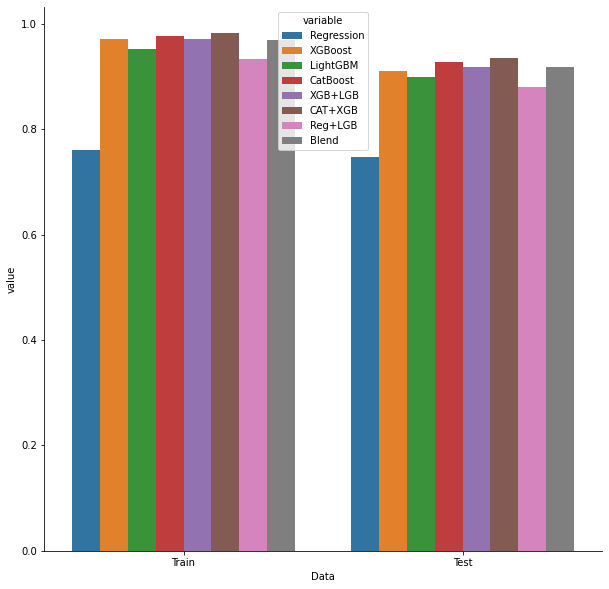

In [27]:
from matplotlib import pyplot as plt
predict = lambda clf, data: [accuracy_score(clf(x), y) for x, y in data]
data = [(X_train, y_train), (X_test, y_test)]
results = pd.DataFrame({
    "Data": ["Train", "Test"],
    "Regression": predict(reg.predict, data),
    "XGBoost": predict(xgb_clf.predict, data),
    "LightGBM": predict(lambda x: lclf.predict(x).argmax(axis=1), data),
    "CatBoost": predict(cat_clf.predict, data),
    "XGB+LGB": predict(lambda x: blend(x, [xgb_clf.predict_proba, lclf.predict]).argmax(axis=1), data),
    "CAT+XGB": predict(lambda x: blend(x, [xgb_clf.predict_proba, cat_clf.predict_proba]).argmax(axis=1), data),
    "Reg+LGB": predict(lambda x: blend(x, [reg.predict_proba, lclf.predict], weights=[0.3, 0.7]).argmax(axis=1), data),
    "Blend": predict(lambda x: blend(x, classifiers).argmax(axis=1), data),
})
plottable = results.melt(id_vars='Data')
plottable

fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(data=plottable, x="Data", hue="variable", y="value", ax=ax1)
sns.despine(fig)

In [29]:
print(results)

#lclf.save_model('lgb_urgency_balanced.txt', num_iteration=lclf.best_iteration)
#import pickle

# analyzer = vectorizer.analyzer
# with open('tfidf.pkl', 'wb') as f:
#     vectorizer.analyzer = None
#     pickle.dump(vectorizer, f)
#     vectorizer.analyzer = analyzer
#
#
# with open('svd1000.pkl', 'wb') as f:
#     pickle.dump(svd, f)


,Data,Regression,XGBoost,LightGBM,CatBoost,XGB+LGB,CAT+XGB,Reg+LGB,Blend
0,Train,0.759807,0.970169,0.952406,0.977279,0.970919,0.982104,0.932019,0.968561
1,Test,0.746817,0.910636,0.897976,0.926524,0.917220,0.934378,0.880745,0.918363


    Data  Regression   XGBoost  LightGBM  CatBoost   XGB+LGB   CAT+XGB  \
0  Train    0.759807  0.970169  0.952406  0.977279  0.970919  0.982104   
1   Test    0.746817  0.910636  0.897976  0.926524  0.917220  0.934378   

    Reg+LGB     Blend  
0  0.932019  0.968561  
1  0.880745  0.918363  


In [31]:
import pickle

xgb_clf.save_model("xgb_urgency_balanced_acc91.xbm")

# cat_clf.save_model("catboost_urgency_balanced.cbm",
#            format="cbm",
#            export_parameters=None,
#            pool=None)

# with open("reg_urgency_balanced.pkl", "wb")as f:
#    pickle.dump(reg, f)

# from matplotlib import pyplot as plt
# %matplotlib inline
# plt.hist(training_objective)
